In [130]:
using DataFrames, NPZ, Arrow, JLD2
using Statistics, NaNMath
using Plots, StatsPlots
using DifferentialEquations, DiffEqParamEstim, Optim

G(z, zstar) = z < zstar ? z : zstar 
@register G(z, zstar)

"""
Interface limited model for biofilm growth,
assumes that nutrients are infinite
"""
function interface_limited(du, u, p, t)
    h = u[1] 
    α, β, hstar = p
    du[1] = α*G.(h, hstar) - β*h 
    return du
end

"""
Fits the experimental data to the interface 
limited interface model. Returns the best parameters
growth, decay and critical height
"""
function fit_model(prob, tdata, zdata, p)
    # Set problem + dummy parameters
    cost_function = build_loss_objective(prob, Tsit5(), L2Loss(tdata, zdata),
                    maxiters=100000, verbose=false)
    result_bfgs = Optim.optimize(cost_function, p, Optim.BFGS())
    min = result_bfgs.minimizer
    return min 
end

function get_data(Df, strain, repl)
    df =  filter(row -> row.Replicate .== repl && row.Strain .== strain, Df);
    return df.Time, df.avg_height
end


_nanfunc(f, A, ::Colon) = f(filter(!isnan, A))
_nanfunc(f, A, dims) = mapslices(a->_nanfunc(f,a,:), A, dims=dims)
nanfunc(f, A; dims=:) = _nanfunc(f, A, dims)

nanfunc (generic function with 1 method)

In [5]:
Df = jldopen("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/profile_database.jld2", "r")["df"];
Df[557+40, 13] = 172
Df[557+43, 13] = 200
Df[557+44, 13] = 190
Df[557+45, 13] = 180
Df[557+46, 13] = 197
Df[557+47, 13] = 210

# Set problem + dummy parameters
u0, p = [0.1], [0.9, 0.1, 20] # Dummy starting conditions
prob = ODEProblem(interface_limited, u0, (0.0, 50.0), p) # Set the problem

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 1-element Vector{Float64}:
 0.1

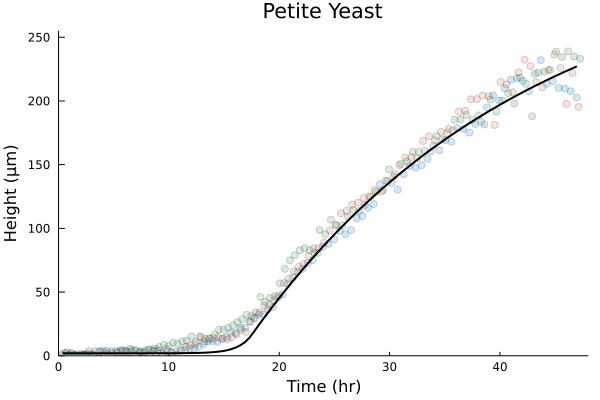

In [241]:
# Petite yeast 

times = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/times.npy")
A = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/profiles_A.npy")
B = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/profiles_B.npy")
C = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/profiles_C.npy")
hA = nanfunc(mean, A[:, 10000:20000], dims=2)
hB = nanfunc(mean, B[:, 10000:20000], dims=2)
hC = nanfunc(mean, C[:, 10000:20000], dims=2)
scatter(times[1,:], hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 230), xlim=(0, 48), title="Petite Yeast")
scatter!(times[2,:], hB, label = false, alpha=0.2)
scatter!(times[3,:], hC, label=false, alpha=0.2, grid=false)

p = [0.85, 0.04, 15.0]
u0 = 0.00001
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=times[1,:])
sol = reduce(vcat, sol.u) .+ 2
p1 = plot!(times[1,:], sol, color=:black, linewidth=2, label=false, ylim=(0, 255))


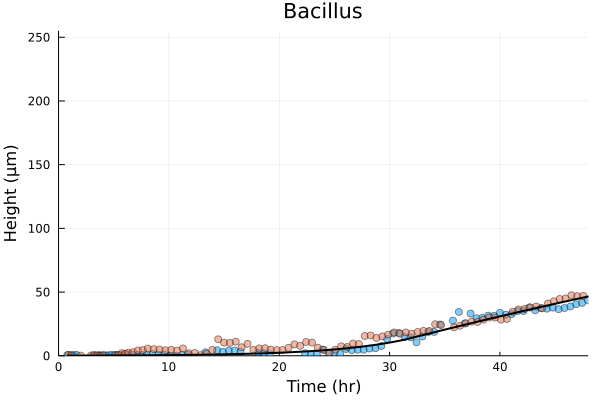

In [212]:
# Bacillus
times = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-30_bacillus/times.npy")
A = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-30_bacillus/profiles_A.npy")
B = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-30_bacillus/profiles_B.npy")
hA = nanfunc(mean, A[:, 10000:20000], dims=2)
hB = nanfunc(mean, B[:, 10000:20000], dims=2)
hB[40:60] .+= -5
scatter(times[1,:], hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 60), xlim=(0, 48), title="Bacillus")
scatter!(times[2,:], hB, label = false, alpha=0.5)

p = [0.156, 0.01, 15.0]
u0 = 0.13
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=times[1,:])
sol = reduce(vcat, sol.u)
p2 = plot!(times[1,:], sol, color=:black, linewidth=2, label=false, ylim=(0,255))

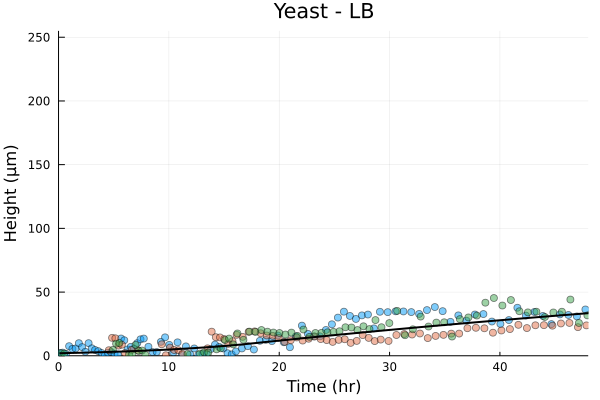

In [213]:
# Yeast 
times = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/times.npy")
A = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/profiles_A.npy")
B = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/profiles_B.npy")
C = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/profiles_C.npy")
hA = nanfunc(mean, A[:, 10000:15000], dims=2)
hB = nanfunc(mean, B[:, 10000:15000], dims=2)
hC = nanfunc(mean, C[:, 10000:15000], dims=2)
hA[20:30] .+= 10
hB[1:30] .+= -15
hC[20:30] .+= -15
hA = abs.(hA)
scatter(times[1,:], hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 50), xlim=(0, 48), title="Yeast - LB")
scatter!(times[2,:], hB, label = false, alpha=0.5)
scatter!(times[3,:], hC, label=false, alpha=0.5)

p = [0.1, 0.01, 10.0]
u0 = 2.0
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=times[1,:])
sol = reduce(vcat, sol.u)
p3 = plot!(times[1,:], sol, color=:black, linewidth=2, label=false, ylim=(0, 255))

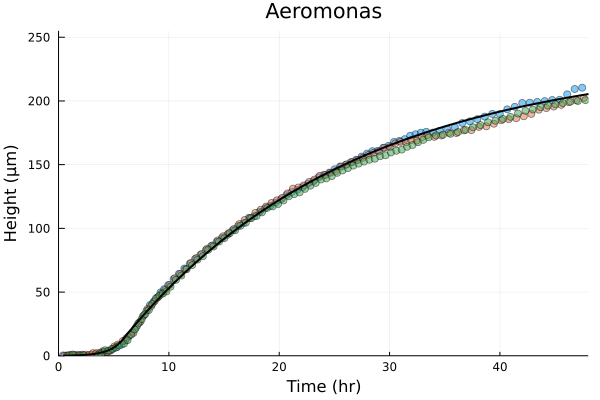

In [214]:
# Aeromonas
tA, hA = get_data(Df, "BGT127", "A")
tB, hB = get_data(Df, "BGT127", "B")
tC, hC = get_data(Df, "BGT127", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="Aeromonas")
scatter!(tB, hB, label = false, alpha=0.5)
scatter!(tC, hC, label=false, alpha=0.5)

p = [0.88, 0.048, 12.8]
u0 = 0.1
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=tA)
sol = reduce(vcat, sol.u)
p4 = plot!(tA, sol, color=:black, linewidth=2, label=false, ylim=(0, 255))


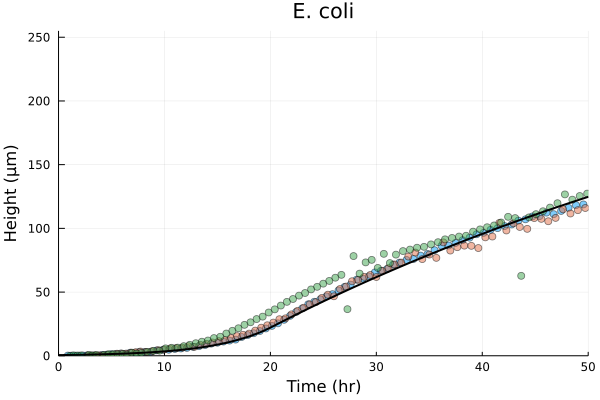

In [232]:
# Ecoli
tA, hA = get_data(Df, "JT305L", "A")
tB, hB = get_data(Df, "JT305L", "B")
tC, hC = get_data(Df, "JT305L", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="E. coli")
scatter!(tB, hB, label = false, alpha=0.5)
scatter!(tC, hC, label=false, alpha=0.5)

p = [0.20, 0.0155, 23.1]
u0 = 0.55
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p5 = plot!(sol, color=:black, linewidth=2, xlabel="Time (hr)", label=false, ylim=(0, 255))

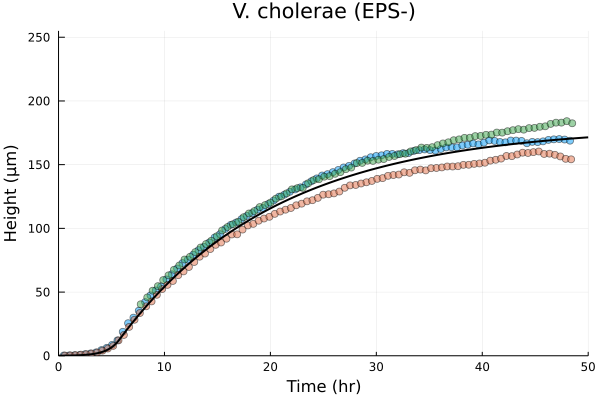

In [233]:
# Vibrio cholerae (EPS-)
tA, hA = get_data(Df, "SN503", "A")
tB, hB = get_data(Df, "SN503", "B")
tC, hC = get_data(Df, "SN503", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="V. cholerae (EPS-)")
scatter!(tB, hB, label = false, alpha=0.5)
scatter!(tC, hC, label=false, alpha=0.5)

p = [0.95, 0.067, 12.7]
u0 = 0.08
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p6 = plot!(sol, color=:black, linewidth=2, xlabel="Time (hr)", label=false, ylim=(0, 255))

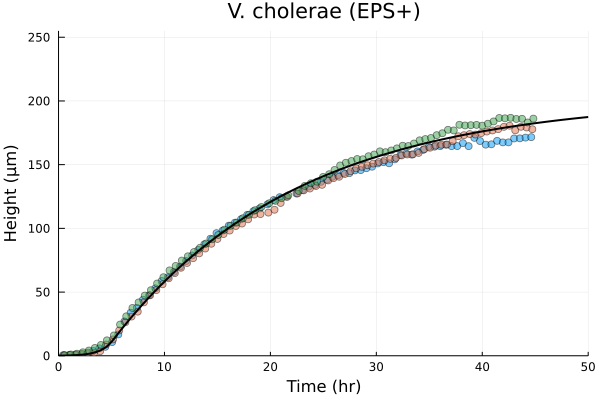

In [234]:
# Vibrio cholerae (EPS+)
tA, hA = get_data(Df, "JT1080", "A")
tB, hB = get_data(Df, "JT1080", "B")
tC, hC = get_data(Df, "JT1080", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="V. cholerae (EPS+)")
scatter!(tB, hB, label = false, alpha=0.5)
scatter!(tC, hC, label=false, alpha=0.5)

p = [0.96, 0.057, 12.0]
u0 = 0.12
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p7 = plot!(sol, color=:black, linewidth=2, label=false, xlabel="Time (hr)", ylim=(0, 255))

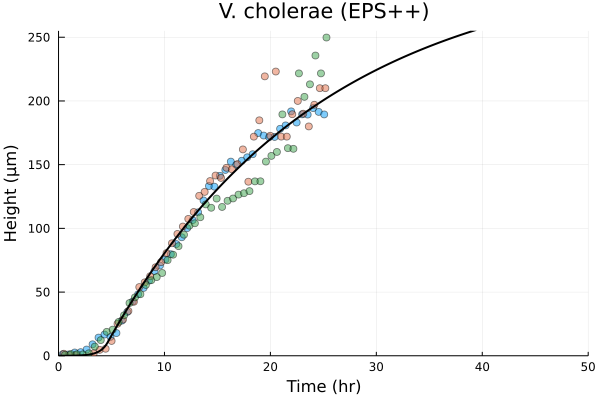

In [235]:
# Vibrio cholerae (EPS++)
tA, hA = get_data(Df, "BH1543", "A")
tB, hB = get_data(Df, "BH1543", "B")
tC, hC = get_data(Df, "BH1543", "C")

hB[40] = 172
hB[43] = 200
hB[44] = 190
hB[45] = 180
hB[46] = 197
hB[47] = 210

hA = abs.(hA)
scatter(tA, hA, alpha=0.5, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="V. cholerae (EPS++)")
scatter!(tB, hB, label = false, alpha=0.5)
scatter!(tC, hC, label=false, alpha=0.5)

p = [1.4, 0.05, 11.0]
u0 = 0.02
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p8 = plot!(sol, color=:black, linewidth=2, label=false, xlabel="Time (hr)", ylim=(0, 255))

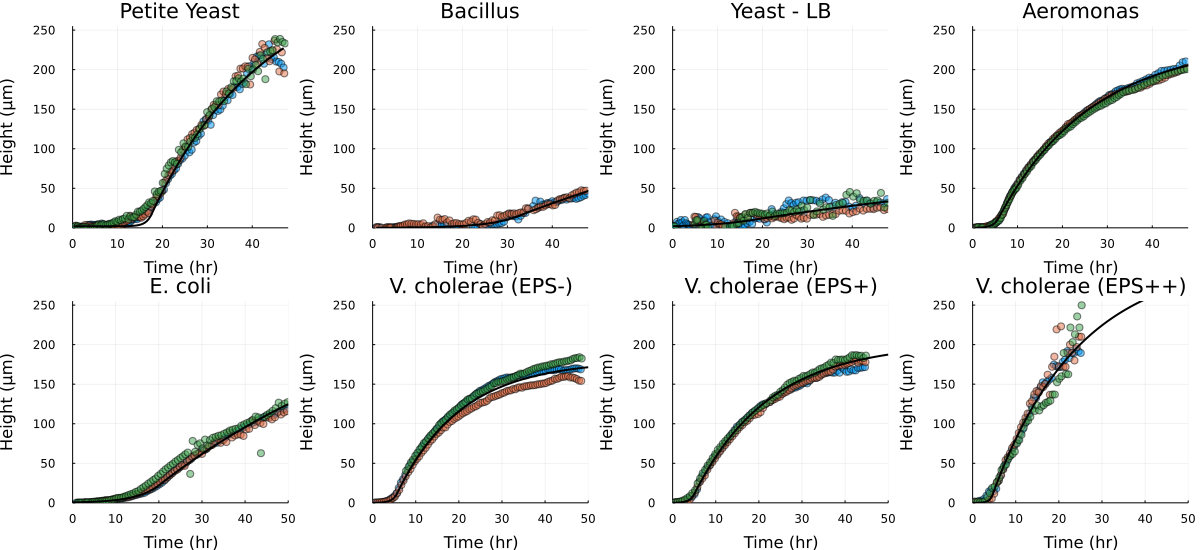

In [236]:
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (2, 4), size=(1200,550), left_margin=4mm, bottom_margin=3mm)

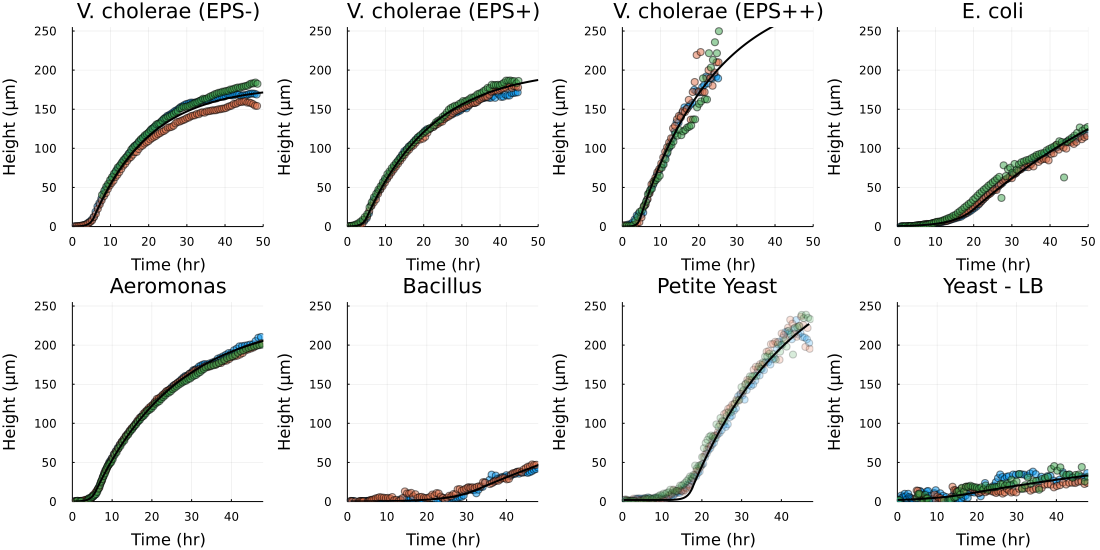

In [244]:
plot(p6, p7, p8, p5, p4, p2, p1, p3, layout = (2, 4), size=(1100,550), left_margin=4mm, bottom_margin=3mm)